This notebook investigates how viral mimics and random viral proteins look when compared against the protein they mimic or similar proteins.

We curated the metadata sheets by hand.
Note that we pulled out examples of viral mimics by name, we did not ensure that they have been experimentally validated or the veracity of the names.
(Ex we grabbed `interleukin-10__YP_081552__Human_betaherpesvirus_5__10359` because it has interleukin 10 in the name so we assume it mimics IL10.)

We calculcated the all-by-all comparisons using foldseek (version `9.427df8a`) using the command:
```
foldseek easy-search all_structures_combined all_structures_combined all-v-all.tsv tmp_foldseek --alignment-type 1 --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```

## Notebook setup

In [8]:
setwd("..")

In [44]:
library(tidyverse)

## Read in and format metadata

In [6]:
# This was initially a Google sheet created by Emily to match structure names to protein or mimic names.
# I downloaded the sheet and it is now available in the same folder as this notebook.
# This sheet (now a separate TSV) records the UniProt ID, species, and protein name for some eukaryotic proteins that are mimicked by viruses.
euk_info <- read_tsv("20241205-posctrl-other-animals-and-human.tsv", show_col_types = FALSE) %>%
  rename(type = gene, filename=uniprotid) %>%
  mutate(type = gsub("IL-10", "IL10", type)) %>%
  mutate(type = tolower(type))

head(euk_info)

filename,type,species
<chr>,<chr>,<chr>
Q8BJW6,eif2a,mouse
Q5ZKC1,eif2a,chicken
Q7ZY11,eif2a,frog
Q4QRJ7,eif2a,zebrafish
Q9VNX8,eif2a,fruitfly
Q25BC1,il10,red fox


In [10]:
# This sheet (now a separate TSV) records the nomburg et al. structure name and protein name for some viral proteins that mimic host proteins.
# This sheet also contains random viral proteins that do NOT mimic the specific host proteins we're investigating (ex. don't mimic IL10).
viral_info <- read_tsv("20241205-posctrl-virus.tsv", show_col_types = FALSE) %>%
  rename(filename = nomburg_structure_file_name, type = mimic) %>%
  mutate(type = tolower(type)) %>%
  mutate(species = "viral")

head(viral_info)

filename,type,species
<chr>,<chr>,<chr>
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral
interleukin-10_BCRF1__YP_401634__Human_gammaherpesvirus_4__10376,il10,viral
ORF127_IL-10-like_protein__NP_957904__Orf_virus__10258,il10,viral
interleukin-10__YP_004936071__Cercopithecine_betaherpesvirus_5__50292,il10,viral
interleukin-10__NP_783792__Human_herpesvirus_5__10359,il10,viral
interleukin-10__YP_081552__Human_betaherpesvirus_5__10359,il10,viral


In [11]:
all_info <- bind_rows(viral_info, euk_info)

## Experiment

We were curious how known viral mimics look when compared to the proteins they mimic or to homologs of that protein in other vertebrates.
We were also curious how random, non-mimic proteins look when compared against these same proteins.

We gathered the following protein structures and performed an all-by-all comparion.
We then pulled out the comparisons for specific or random viral mimics against the thing they're mimicing and looked at the results.

In [13]:
all_v_all <- read_tsv("all-v-all.tsv", show_col_types = FALSE) %>%
  # edit the structure names
  mutate(query = gsub(".pdb", "", query),
         target = gsub(".pdb", "", target),
         target = gsub("AF-", "", target),
         target = gsub("-F1-model_v4", "", target),
         query = gsub("AF-", "", query),
         query = gsub("-F1-model_v4", "", query)) %>%
  # correct alignment tmscores, which are wrong when output by foldseek
  mutate(tmraw1 = qtmscore * qlen,
         tmraw2 = ttmscore * tlen,
         tmraw = (tmraw1 + tmraw2) / 2,
         alntmscore = tmraw/alnlen)

In [14]:
# join the viral and eukaryotic metadata to the comparison results
tmp <- all_info %>% right_join(all_v_all, by = c("filename" = "target")) %>%
  rename(target = filename, target_type = type, target_species = species)

combined <- all_info %>% right_join(tmp, by = c("filename" = "query")) %>%
  rename(query = filename, query_type = type, query_species = species)

### IL10

In [18]:
il10 <- combined %>%
  filter(query_type %in% c("il10", "random")) %>%
  filter(query_species == "viral") %>%
  filter(target_species != "viral") %>%
  filter(!target_type %in% c("c4bp", "eif2a", "elf2a", "random", "il18bp")) %>%
  mutate(target_type = ifelse(target_type == "il10_human", "il10", target_type),
         target_type = ifelse(grepl(x = target_type, pattern = "_human"), "human cytokine", target_type))

il10

query,query_type,query_species,target,target_type,target_species,qlen,tlen,alnlen,alntmscore,⋯,tseq,qstart,qend,tstart,tend,qaln,taln,tmraw1,tmraw2,tmraw
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,Q25BC1,il10,red fox,170,179,151,0.95872119,⋯,MPSPALLCCCLVLLAGVGASRHQSTLSEDDCTHFPASLPHMLRELRAAFGRVKTFFQMKDKLDNILLTGSLLEDFKGYLGCQALSEMIQFYLEEVMPRAENHDPDIKDHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVEQVKSAFSKLQEKGVYKAMSEFDIFINYIETYMTMRMKI,21,170,28,178,CGGTDQCD-NFPQMLRDLRDAFSRVKTFFQTKDEVDNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRRCHRFLPCENKSKAVEQIKNAFNKLQEKGIYKAMSEFDIFINYIEAYMTIKAR,EDDCTHFPASLPHMLRELRAAFGRVKTFFQMKDKLDNILLTGSLLEDFKGYLGCQALSEMIQFYLEEVMPRAENHDPDIKDHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVEQVKSAFSKLQEKGVYKAMSEFDIFINYIETYMTMRMK,144.687,144.84680,144.76690
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,Q6A2H4,il10,chicken,170,175,173,0.88276445,⋯,MQTCCQALLLLLAACTLPAHCLEPTCLHFSELLPARLRELRVKFEEIKDYFQSRDDELNIQLLSSELLDEFKGTFGCQSVSEMLRFYTDEVLPRAMQTSTSHQQSMGDLGNMLLGLKATMRRCHRFFTCEKRSKAIKQIKETFEKMDENGIYKAMGEFDIFINYIEEYLLMRRRK,2,170,4,174,E-RRLVVTLQCLVLLYLAPECGGT-DQC-DNFPQMLRDLRDAFSRVKTFFQTKDEV-DNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRRCHRFLPCENKSKAVEQIKNAFNKLQEKGIYKAMSEFDIFINYIEAYMTIKAR,CCQALLLLLAA-CTL-PAHCLEPTCLHFSELLPARLRELRVKFEEIKDYFQSRDDELNIQLLSSELLDEFKGTFGCQSVSEMLRFYTDEVLPRAMQTSTSHQQSMGDLGNMLLGLKATMRRCHRFFTCEKRSKAIKQIKETFEKMDENGIYKAMGEFDIFINYIEEYLLMRRR,152.609,152.82750,152.71825
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,Q2PE73,il10,swamp buffalo,170,179,156,0.91710545,⋯,MPSSSALLCCLVFLAGVAASRDASTLSDSSCTQFPTSLPHMLRELRAAFSRVKTFFQMKDQLDSLLLTQSLLDDFKGYLGCQALSEMIQFYLEEVMPQAENHGPDIKEHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVEQVKRAFSKLQDRGVYKAMSEFDIFINYIETYVTTKMQK,18,170,24,178,AP--ECG-GTDQCDNFPQMLRDLRDAFSRVKTFFQTKDEVDNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRRCHRFLPCENKSKAVEQIKNAFNKLQEKGIYKAMSEFDIFINYIEAYMTIKAR,STLS-DSSCTQFPTSLPHMLRELRAAFSRVKTFFQMKDQLDSLLLTQSLLDDFKGYLGCQALSEMIQFYLEEVMPQAENHGPDIKEHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVEQVKRAFSKLQDRGVYKAMSEFDIFINYIETYVTTKMQ,142.919,143.21790,143.06845
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,Q9JHK7,il10,wood chuck,170,178,117,0.85677949,⋯,MPNPVLLYCLVLLAGMGTSQGENTQSEETCTHFPGGLPHMLRELRAAFGRVKIFFQTKDQLDDMLLSESLLEDFKGYLGCQALSEMIQFYLVEVMPQAENHSPDVKEHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVQQVKDAFSKLQEKGIYKAMSEFDIFINYIEAYMTAKINS,14,126,20,133,L--LYLAP-ECG-GTDQCDNFPQMLRDLRDAFSRVKTFFQTKDEVDNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRRCHRFLPCE,QGE---NTQSEETCTHFPGGLPHMLRELRAAFGRVKIFFQTKDQLDDMLLSESLLEDFKGYLGCQALSEMIQFYLVEVMPQAENHSPDVKEHVNSLGEKLKTLRLRLRRCHRFLPCE,100.130,100.35640,100.24320
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,P48411,il10,dog,170,181,152,0.94333158,⋯,MHGSALLCCCLVLLAGVGASRHQSTLLEDDCTHFPASLPHMLRELRAAFGRVKIFFQMKDKLDNILLTGSLLEDFKSYLGCQALSEMIQFYLEEVMPRAENHDPDIKNHVNSLGEKLKTLRLRLRLRRCHRFLPCENKSKAVEQVKSAFSKLQEKGVYKAMSEFDIFINYIETYMTMRMKI,21,170,29,180,CGGTDQCDNFPQMLRDLRDAFSRVKTFFQTKDEVDNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRR--CHRFLPCENKSKAVEQIKNAFNKLQEKGIYKAMSEFDIFINYIEAYMTIKAR,DDCTHFPASLPHMLRELRAAFGRVKIFFQMKDKLDNILLTGSLLEDFKSYLGCQALSEMIQFYLEEVMPRAENHDPDIKNHVNSLGEKLKTLRLRLRLRRCHRFLPCENKSKAVEQVKSAFSKLQEKGVYKAMSEFDIFINYIETYMTMRMK,143.276,143.49680,143.38640
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,il10,viral,Q29408,il10,sheep,170,177,172,0.89766483,⋯,MPSSSAVLCCLVFLAGVAASRDASTLSDSSCTHFPASLPHMLRDVRAAFGKVKTFFQMKDQLNSMLLTQSLLDDFKGYLGCQALSEMIQFYLEEVMPQAENHGPDIKEHVNSLGEKLKTLRLRLRRCHRFLPCENKSKAVEQVKRVFNMLQERGVYKAMSEFDIFINYIESYMTTKM,1,169,10,177,MERRLVVTLQCLVLLYLAPEC--GGTDQCD-NFPQMLRDLRDAFSRVKTFFQTKDEVDNLLLKESLLEDFKGYLGCQALSEMIQFYLEEVMPQAENQDPEAKDHVNSLGENLKTLRLRLRRCHRFLPCENKSKAVEQIKNAFNKLQEKGIYKAMSEFDIFINYIEAYMTIKA,CLVF-LA--GV-AASRDASTLSDSSCTHFPASLPHMLRDVRAAFGKVKTFFQMKDQLNSMLLTQSLLDDFKGYLGCQA

The **top plot** labelled "il10" shows viral IL10 mimics compared to either
1. Human or other vertebrate IL10s (red fox, chicken, swamp buffalo, wood chuck, dog, sheep)
2. Human cytokines (NOT IL10).

This plot shows that for the majority of comparisons, the viral IL10s are mostly more similar to IL10 than they are to other human cytokines.
There are a few viral IL10s with lower similarity, but these all come from Betaherpesvirus 5s and have low TM-scores when compared to all of the euk IL10s.
This might suggest that these structures aren't actually an IL10 mimics or that they're different from the other mimics in some way.


The **bottom plot** labelled "random" shows random viral proteins compared against either human/vertebrate IL10s or other human cytokines.
Surprisingly, random viral structures can reach and `alntmscore` of up to/in excess of 0.5.
This means that we should expect a random viral protein to have high homology to a random human protein, likely because this isn't a random scenario at all: these viruses are adapted to human hosts and many have had prolific HGT with host proteins throughout their evolution.
This appears to drive up background structural similarity between random sets of viral proteins and "random" human proteins (here, these are all human immune proteins [cytokines], and we know that viruses disproportionately impact the human immune system to acheive their goals of replication and transmission).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


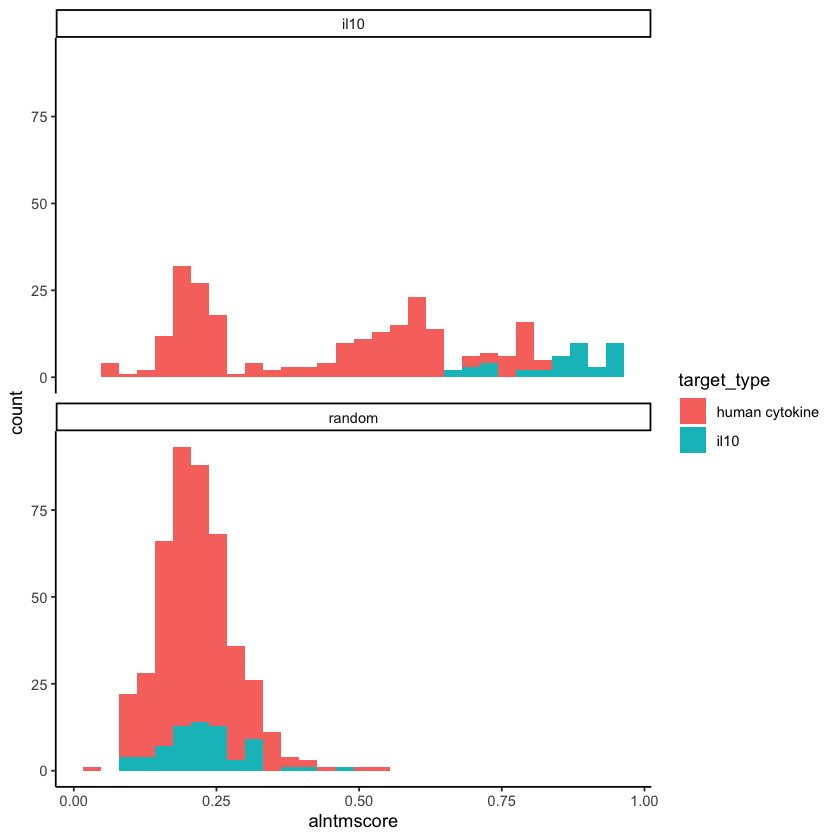

In [19]:
ggplot(il10, aes(x = alntmscore, fill = target_type, text = target_species)) +
  geom_histogram() +
  theme_classic() +
  facet_wrap(~query_type, ncol = 1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


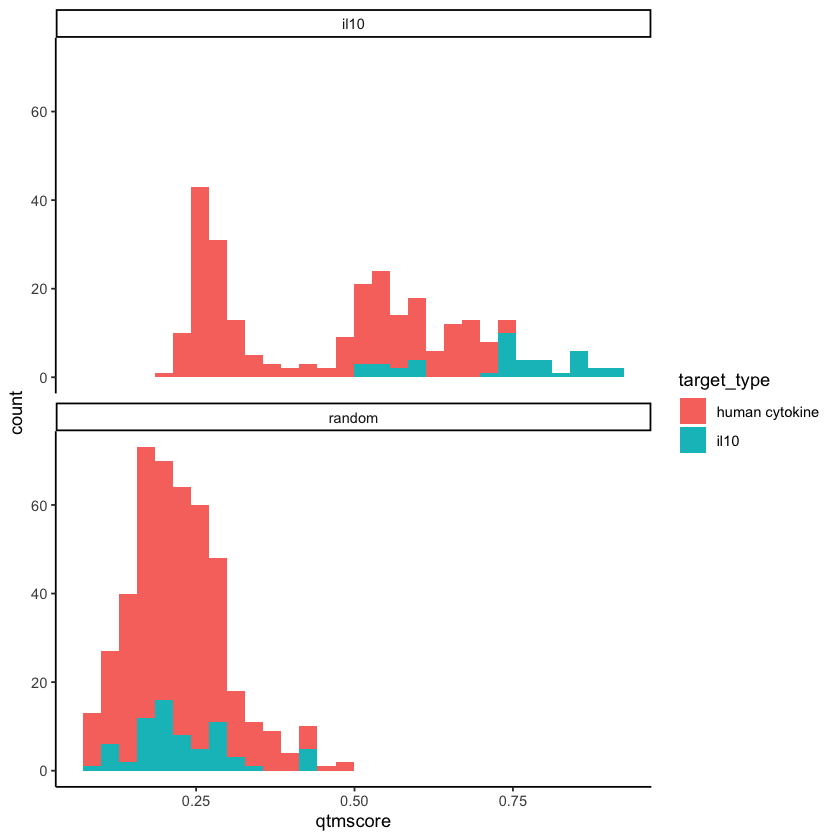

In [29]:
ggplot(il10, aes(x = qtmscore, fill = target_type, text = target_species)) +
  geom_histogram() +
  theme_classic() +
  facet_wrap(~query_type, ncol = 1)

In [32]:
# pull out the viral IL10 vs. euk IL10 results so we can see which specific structures had better or worse hits.
il10 %>% 
  filter(query_type == "il10") %>%
  filter(target_type == "il10") %>%
  select(-query_type, -query_species, -tmraw1, -tmraw2, -tmraw, -cigar,
         -qseq, -tseq, -qstart, -qend, -tstart, -tend, -qaln, -taln) %>%
  arrange(desc(alntmscore))
  

query,target,target_type,target_species,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,Q25BC1,il10,red fox,170,179,151,0.9587212,0.8511,0.8092,0.9121,0.991,0.882,0.844,76.8,84,0.8233
interleukin-10_BCRF1__YP_401634__Human_gammaherpesvirus_4__10376,Q25BC1,il10,red fox,170,179,151,0.9557758,0.8485,0.8067,0.9111,0.991,0.882,0.844,76.8,84,0.8215
interleukin-10_BCRF1__YP_401634__Human_gammaherpesvirus_4__10376,Q2PE73,il10,swamp buffalo,170,179,151,0.9535831,0.8465,0.8049,0.9039,0.990,0.882,0.844,75.4,83,0.8182
ORF127_IL-10-like_protein__NP_957904__Orf_virus__10258,Q25BC1,il10,red fox,184,179,153,0.9517487,0.7916,0.8133,0.9174,0.978,0.832,0.832,83.6,78,0.7982
ORF127_IL-10-like_protein__NP_957904__Orf_virus__10258,Q29408,il10,sheep,184,177,158,0.9504155,0.8164,0.8481,0.9063,0.986,0.853,0.881,89.8,81,0.8267
ORF127_IL-10-like_protein__NP_957904__Orf_virus__10258,Q2PE73,il10,swamp buffalo,184,179,155,0.9456742,0.7969,0.8186,0.9163,0.981,0.842,0.855,86.4,79,0.8008
ORF127_IL-10-like_protein__NP_957904__Orf_virus__10258,Q6A2H4,il10,chicken,184,175,156,0.9442144,0.8011,0.8411,0.8444,0.981,0.842,0.880,44.2,79,0.8122
BCRF1__YP_001129439__Human_herpesvirus_4_type_2__12509,P48411,il10,dog,170,181,152,0.9433316,0.8428,0.7928,0.8956,0.990,0.882,0.840,74.3,83,0.8096
interleukin-10_BCRF1__YP_401634__Human_gammaherpesvirus_4__10376,P48411,il10,dog,170,181,153,0.9415176,0.8468,0.7964,0.9118,0.990,0.882,0.840,73.8,83,0.8150


Scrolling in the able above, we can see the human IL10 hits all have somewhat low qtmscores (even though some of the alntmscores are very high).
We think this might be in part due to the human structure of IL10 itself.
There's a particular domain that it's hard to align against, dropping the qtmscore.

### IL18BP

We next wanted to see whether the same patterns hold true for IL18BP that we observed for IL10.
Because IL10 is a cytokine and therefore part of a large family of similar proteins (all other cytokines), we had pulled out all of the human cytokine proteins to compare IL10 against.
We didn't have time to curate a similar set of proteins for IL18BP, so we continue with the same set up and only compare against IL18BP and human cytokines (except not IL10).

Because there is not a lot of similarity between IL18BP and interleukins, we see more separation between the scores of viral mimics of il18bp compare against vertebrate il18bp and viral mimics of il18bp compared against human cytokines.
We would expect this result.
However, we still see high similarity between random viral proteins and vertebrate IL18BP.

In [39]:
il18bp <- combined %>%
  filter(query_type %in% c("il18bp", "random")) %>%
  filter(query_species == "viral") %>%
  filter(target_species != "viral") %>%
  filter(!target_type %in% c("c4bp", "eif2a", "elf2a", "random", "il10")) %>%
  mutate(target_type = ifelse(grepl(x = target_type, pattern = "_human"), "human cytokine", target_type))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


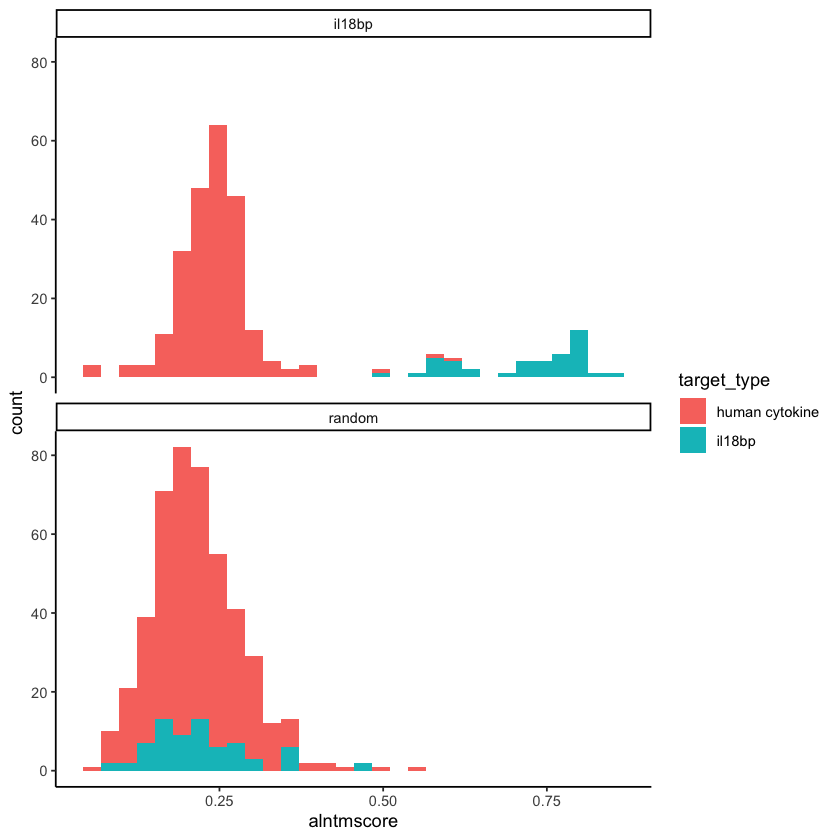

In [43]:
# alignment tmscores
ggplot(il18bp, aes(x = alntmscore, fill = target_type, text = target_species)) +
       geom_histogram() +
       theme_classic() +
       facet_wrap(~query_type, ncol = 1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


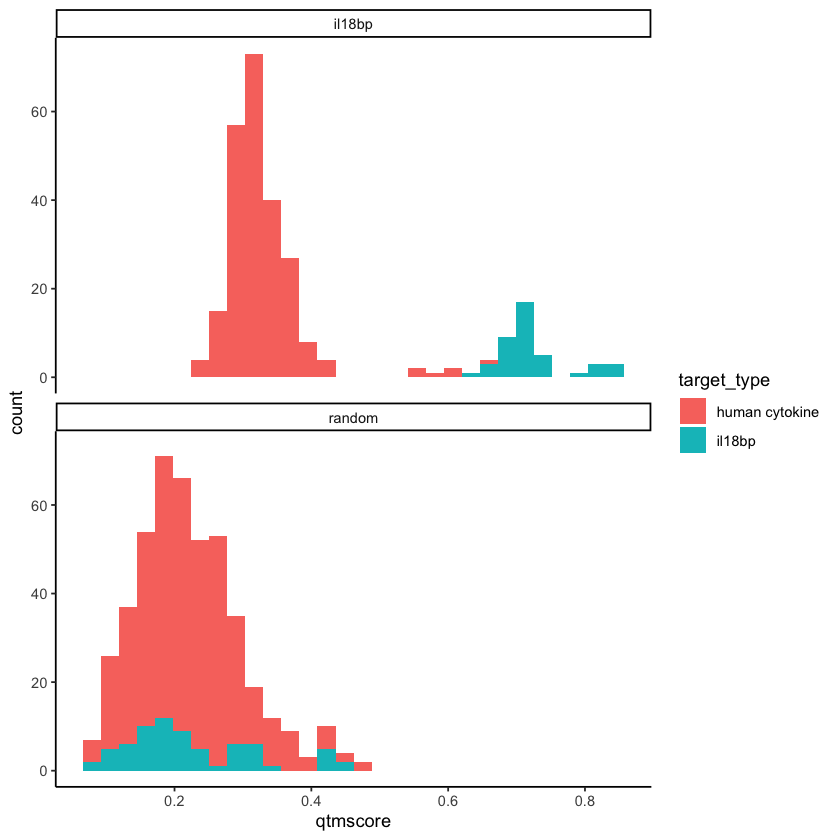

In [41]:
# query tmscore
ggplot(il18bp, aes(x = qtmscore, fill = target_type, text = target_species)) +
       geom_histogram() +
       theme_classic() +
       facet_wrap(~query_type, ncol = 1)

In [42]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.4 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [5] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
 [9] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.5.0.1       gtable_0.3.6      jsonlite_1.8.9    compiler_4.3.3   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     parallel_4.3.3   
 [9] scales_1.3.0      uuid_1.2-1        fastmap_1.2.0     IRkernel_1.3.2   
[13] R6_2.5.1          labeling_0